In [1]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50V2
from keras.applications import MobileNetV2

2023-04-04 00:11:03.454901: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<h2>ResNet50V2</h2>
<img width="80%" alt="ResNet50V2" src="ResNet50V2.png">

<h2>MobileNetV2</h2>
<img width="80%" alt="MobileNetV2" src="ResNet50V2.png">

In [2]:
ResNet50V2_Accuracies = [0.97309, 0.91875]
MobileNetV2_Accuracies = [0, 0]
pd.DataFrame({"ResNet50V2": ResNet50V2_Accuracies, "MobileNetV2": MobileNetV2_Accuracies},
             index=["Train Accuracy", "Test Accuracy"])

,ResNet50V2,MobileNetV2
Train Accuracy,0.97309,0
Test Accuracy,0.91875,0


In [3]:
TEST_PATH = "dataset/test/"
TEST_DIRS = glob.glob("dataset/test/*")

MODEL_PATH = "ResNet50V2.h5"  # ResNet50V2.h5, MobileNetV2.h5

In [4]:
def load_model():
    net = ResNet50V2(
        weights="imagenet",
        include_top=False,
    )
    for layer in net.layers:
        layer.trainable = False
    x = net.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation="relu")(x)
    predictions = Dense(len(TEST_DIRS), activation="softmax")(x)
    model = Model(inputs=net.input, outputs=predictions)
    model.load_weights(MODEL_PATH)
    return model

In [5]:
model = load_model()

2023-04-04 00:11:11.908665: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
test_data = [j for sub in [glob.glob(f"{test_dir}/*") for test_dir in TEST_DIRS] for j in sub]

In [7]:
sampled_test_data = random.sample(test_data, 9)

In [8]:
test_datagen = ImageDataGenerator(rescale=1 / 255)
test_data = test_datagen.flow_from_directory(
        TEST_PATH,
        color_mode="rgb",
        shuffle = False,
        class_mode='categorical',
        batch_size=1)
filenames = test_data.filenames
predictions = model.predict(test_data, steps=len(filenames))

Found 160 images belonging to 5 classes.
160/160 [==============================] - 19s 108ms/step


In [9]:
predicted_class_indices = np.argmax(predictions, axis=1)
predicted_classnames = []
true_classnames = []
for i in range(len(filenames)):
    predicted_classnames.append(list(test_data.class_indices.keys())[predicted_class_indices.item(i)])
    true_classnames.append(list(test_data.class_indices.keys())[test_data.labels[i]])
results = pd.DataFrame({"Filename": filenames,
                        "Prediction": predicted_classnames,
                        "True": true_classnames})
results.sample(10)

,Filename,Prediction,True
137,assam pedas/CLA2AMO66BI982PQ7TZ5V072.jpg,assam pedas,assam pedas
91,Apricot/L5K24R2HKBCCQ0BRWNEJBBX0.jpg,Apple,Apricot
147,assam pedas/LFTIP0V6K1UG7QUEBFDSHG48.jpg,assam pedas,assam pedas
100,Avocados/3F696OTM9O1GT9LPRJQ838YA.jpg,Avocados,Avocados
102,Avocados/67BJTOPN0XJWBGBXSHU0UHV6.jpg,Avocados,Avocados
17,Alcoholic Beverage/EXI1DQEIC3ZL5OPO7CWBAA2A.jpg,Alcoholic Beverage,Alcoholic Beverage
124,Avocados/SMHWNBLSL54KVVXCKRCZKKL8.jpg,Avocados,Avocados
154,assam pedas/TO4G7OKDVJ43N1W576SZYSRC.jpg,assam pedas,assam pedas
11,Alcoholic Beverage/5WTM75780SECRWDUJVOZVWX7.jpg,Alcoholic Beverage,Alcoholic Beverage
125,Avocados/WLK9JCMSRQ07DCUHKWYCO3OY.jpg,Avocados,Avocados


In [10]:
test_accuracy = results.loc[(results["Prediction"] == results["True"])].shape[0] / results.shape[0]
print("Test Accuracy: " + str(test_accuracy))

Test Accuracy: 0.91875


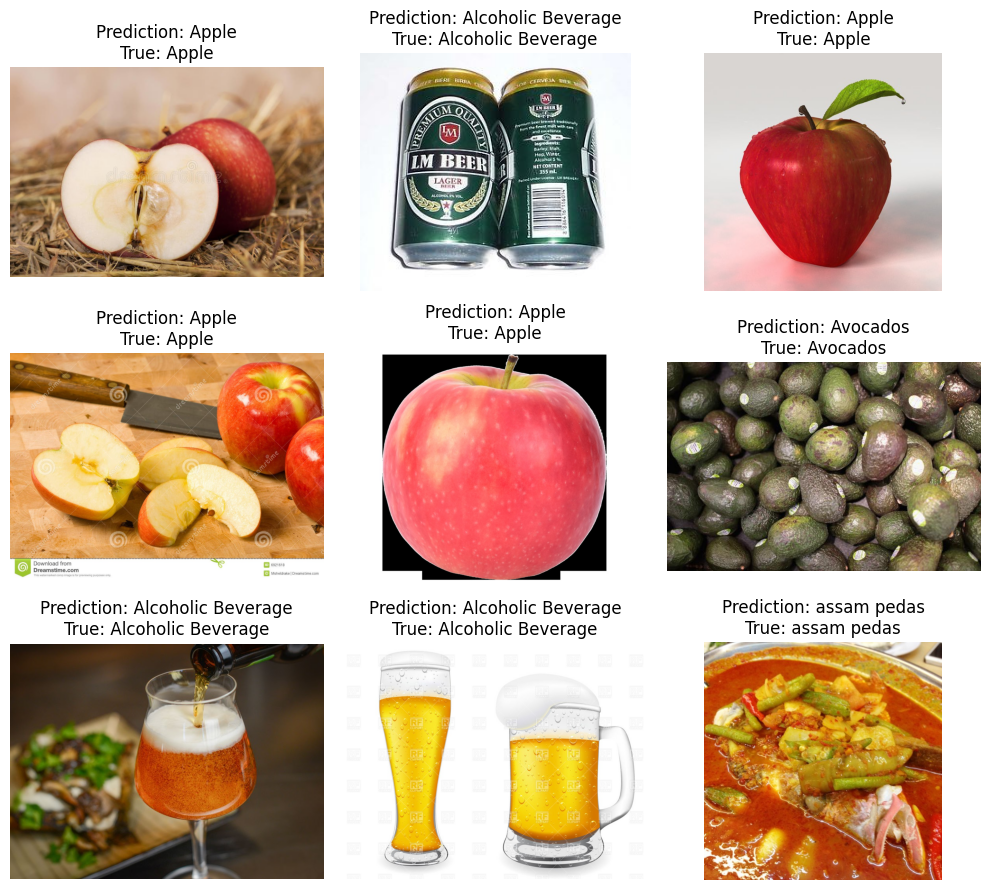

In [11]:
plt.figure(figsize=(10, 9))

for idx, row in results.sample(9).reset_index(drop=True).iterrows():
    plt.subplot(3, 3, idx + 1)
    img = plt.imread(TEST_PATH + row["Filename"])
    plt.title("Prediction: " + row["Prediction"] + "\nTrue: " + row["True"])
    plt.imshow(img, cmap="gray")
    plt.axis("off")

plt.tight_layout()

In [12]:
mismatched_results = results.loc[~(results["Prediction"] == results["True"])]
len(mismatched_results)

13

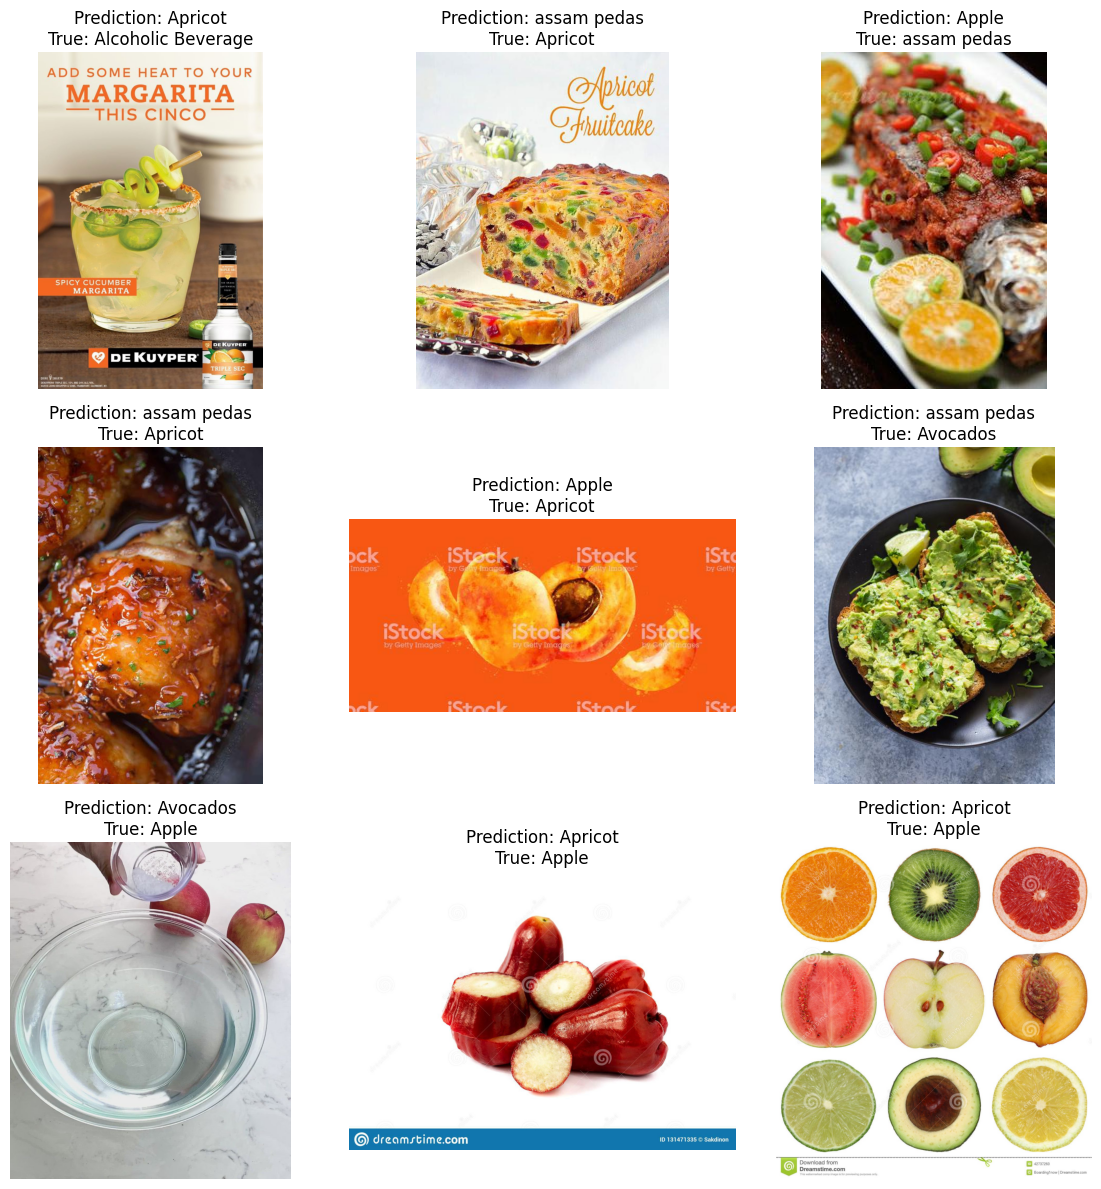

In [13]:
plt.figure(figsize=(12, 12))

for idx, row in mismatched_results.sample(9).reset_index(drop=True).iterrows():
    plt.subplot(3, 3, idx + 1)
    img = plt.imread(TEST_PATH + row["Filename"])
    plt.title("Prediction: " + row["Prediction"] + "\nTrue: " + row["True"])
    plt.imshow(img, cmap="gray")
    plt.axis("off")

plt.tight_layout()